In [1]:
include("benchFunctions.jl")
using PrettyTables

In [11]:
fp32 = true

if fp32
    println("Using Float32 data")
    example_filepath = "resuts_adjoint_GH200_f32.csv";
else
    println("Using Float64 data")
    example_filepath = "resuts_adjoint_GH200_f64.csv";
end


my_df = read_special_csv(example_filepath);


# println("DataFrame letto con successo:")
# println(my_df)

# required_cols = ["cluster_size", "tet_per_block", "nelements", "clock", "Throughput"]
# missing_cols = setdiff(required_cols, names(my_df))

# println("Colonne richieste mancanti: ", missing_cols)
# println("Colonne presenti nel DataFrame: ", names(my_df))

# grouped = groupby(my_df, [:cluster_size, :tet_per_block])


Using Float32 data


Top 15 rows with maximum Throughput:




Row,cluster_size,tet_per_block,min_clock,max_clock,mean_clock,se_clock,min_Throughput,max_Throughput,mean_Throughput,se_Throughput
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,4,0.153991,0.156251,0.154588,0.000195453,1.59632e8,1.61974e8,1.61351e8,2.0238e5
2,8,4,0.154117,0.156648,0.154978,0.000239128,1.59227e8,1.61842e8,1.60946e8,247199.0
3,4,4,0.150586,0.159856,0.155795,0.000917152,1.56032e8,1.65637e8,1.60149e8,9.47147e5
4,12,4,0.156965,0.159206,0.157705,0.000220514,1.56669e8,1.58905e8,1.58163e8,2.20334e5
5,4,6,0.159235,0.160917,0.159733,0.000145552,1.55003e8,1.5664e8,1.56153e8,1.41591e5
6,16,4,0.160853,0.163682,0.162358,0.000306605,1.52384e8,1.55064e8,1.53632e8,290321.0
7,8,6,0.161188,0.163894,0.162604,0.000242085,1.52187e8,1.54742e8,1.53398e8,228490.0
8,1,6,0.163218,0.165091,0.163592,0.000170815,1.51084e8,1.52817e8,1.5247e8,1.57999e5
9,12,6,0.166805,0.169103,0.167694,0.000227335,1.475e8,1.49532e8,1.48742e8,2.01219e5


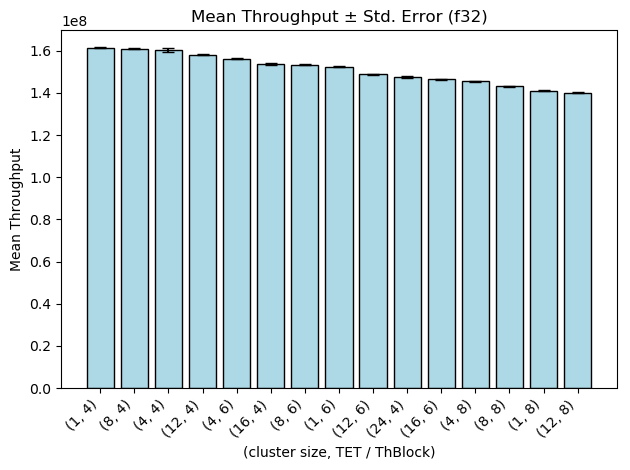

In [12]:

summary_df = summarize_cluster_stats(my_df);
max_row = col_with_max_Throughput(summary_df);

top = 15
max_row_top = cols_within_max_Throughput(summary_df, top);


println("Top $top rows with maximum Throughput:\n\n");
show(stdout, MIME("text/html"), max_row_top);


picture_th = plot_throughput_bars(max_row_top, logy = false, fpFormat = fp32 ? 32 : 64);


In [4]:
summary_df = summarize_cluster_stats(my_df)
println("Cluster stats summary:")
println(summary_df)

Cluster stats summary:
65×10 DataFrame
 Row │ cluster_size  tet_per_block  min_clock  max_clock  mean_clock  se_clock     min_Throughput  max_Throughput  mean_Throughput  se_Throughput  
     │ Int64         Int64          Float64    Float64    Float64     Float64      Float64         Float64         Float64          Float64        
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │            1              4   0.153991   0.156251    0.154588  0.000195453       1.59632e8       1.61974e8        1.61351e8       2.0238e5
   2 │            1              6   0.163218   0.165091    0.163592  0.000170815       1.51084e8       1.52817e8        1.5247e8        1.57999e5
   3 │            1              8   0.176484   0.178641    0.176834  0.000203534       1.39624e8       1.4133e8         1.41052e8       1.60942e5
   4 │            1             12   0.212423   0.214454    0.212886  0.00017